# 0. Imports

In [1]:
from functools import partial

import jax
from jax import vmap
from jax.lax import scan
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

# 1. Stationary 10-armed Bandit Experiment

In [2]:
def stationary_bandit(key, k=10, n=1_000, eps=0., alpha=0, init_reward=0., ucb_c=0.):
    key, subkey = jr.split(key)
    
    # Randomly sample means of the k rewards
    r_means = jr.normal(subkey, shape=(k,))
    
    # Optimal action
    a_optimal = jnp.argmax(r_means)
    
    def _step(carry, args):
        # Carry is sample estimate of rewards
        r_est, counts = carry
        key, i = args
        keys = jr.split(key, 4)
        
        # Make a choice
        idx = jr.permutation(x=len(r_est), key=keys[0])  # Shuffle rewards to randomly break ties
        ucb_criterion = jnp.where(
            counts[idx] == 0,
            jnp.where(ucb_c == 0, r_est[idx], 1e8),
            r_est[idx] + ucb_c * jnp.sqrt(jnp.log(i) / counts[idx])
        )
        choice_g = idx[jnp.argmax(ucb_criterion)]  # Greedy choice
        choice_r = jr.choice(a=idx, key=keys[1])  # Random choice
        choice = jr.choice(
            a=jnp.array([choice_g, choice_r]),
            key=keys[2], 
            p=jnp.array([1-eps, eps])
        )
        chose_optimal = (a_optimal == choice).astype(jnp.float32)
        
        # Receive reward
        r_curr = r_means[choice] + jr.normal(keys[3])
        counts = counts.at[choice].set(counts[choice] + 1)
        r_est = jnp.where(
            alpha > 0 and alpha <= 1,
            r_est.at[choice].set(r_est[choice] + alpha*(r_curr - r_est[choice])),
            r_est.at[choice].set(r_est[choice] + (1/counts[choice])*(r_curr - r_est[choice])),
        )
        
        return (r_est, counts), (r_curr, chose_optimal)

    init = (init_reward * jnp.ones(k), jnp.zeros(k))
    _, (rewards, chose_optimal) = scan(_step, init, (jr.split(key, n), jnp.arange(n)))
    
    return rewards, chose_optimal

In [3]:
def stationary_bandit_experiment(n_iter=2_000, k=10, n=1_000, eps=0., alpha=0.,
                                 init_reward=0., ucb_c=0., key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
        
    keys = jr.split(key, n_iter)
    bandit = lambda key: stationary_bandit(key=key, k=k, n=n, eps=eps, alpha=alpha, 
                                           init_reward=init_reward, ucb_c=ucb_c)
    rewards, chose_optimal = vmap(bandit)(keys)
    
    avg_rewards, avg_optimal_actions = \
        jnp.mean(rewards, axis=0), jnp.mean(chose_optimal, axis=0)
    
    return avg_rewards, avg_optimal_actions

## 1.1 Method Comparison (Figure 2.2)

In [4]:
greedy_result = stationary_bandit_experiment(eps=0.)
ng1_result = stationary_bandit_experiment(eps=0.1)
ng2_result = stationary_bandit_experiment(eps=0.01)

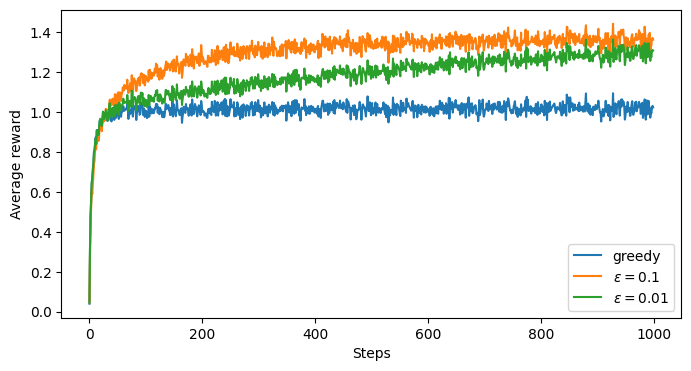

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(greedy_result[0], label="greedy")
ax.plot(ng1_result[0], label=r"$\epsilon=0.1$")
ax.plot(ng2_result[0], label=r"$\epsilon=0.01$")
ax.set_xlabel("Steps")
ax.set_ylabel("Average reward")
ax.legend();

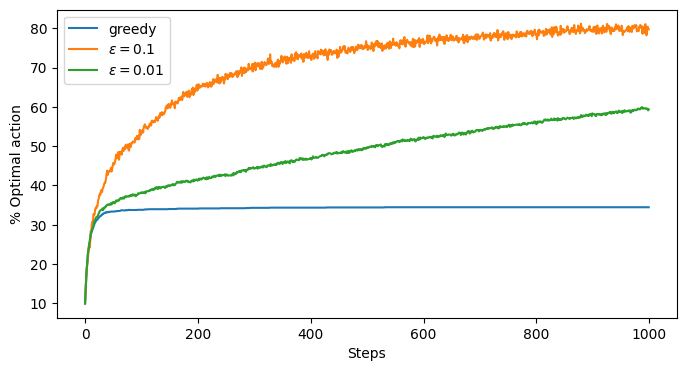

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(greedy_result[1]*100, label="greedy")
ax.plot(ng1_result[1]*100, label=r"$\epsilon=0.1$")
ax.plot(ng2_result[1]*100, label=r"$\epsilon=0.01$")
ax.set_xlabel("Steps")
ax.set_ylabel("% Optimal action")
ax.legend();

# 2. Nonstationary 10-armed Bandit Experiment (Exercise 2.5)

In [7]:
def nonstationary_bandit(key, k=10, n=10_000, eps=0.1, alpha=0, init_reward=0., ucb_c=0.):
    key, subkey = jr.split(key)
    
    def _step(carry, args):
        # Carry is sample estimate of rewards
        r_means, r_est, counts = carry
        key, i = args
        keys = jr.split(key, 5)
        
        # Make a choice
        idx = jr.permutation(x=len(r_est), key=keys[0])  # Shuffle rewards to randomly break ties
        ucb_criterion = jnp.where(
            counts[idx] == 0,
            jnp.where(ucb_c == 0, r_est[idx], 1e8),
            r_est[idx] + ucb_c * jnp.sqrt(jnp.log(i) / counts[idx])
        )
        choice_g = idx[jnp.argmax(ucb_criterion)]  # Greedy choice
        choice_r = jr.choice(a=idx, key=keys[1])  # Random choice
        choice = jr.choice(
            a=jnp.array([choice_g, choice_r]),
            key=keys[2], 
            p=jnp.array([1-eps, eps])
        )
        a_optimal = jnp.argmax(r_means) # Optimal action
        chose_optimal = (a_optimal == choice).astype(jnp.float32)
        
        # Receive reward
        r_curr = r_means[choice] + jr.normal(keys[3])
        counts = counts.at[choice].set(counts[choice] + 1)
        r_est = jnp.where(
            alpha > 0 and alpha <= 1,
            r_est.at[choice].set(r_est[choice] + alpha*(r_curr - r_est[choice])),
            r_est.at[choice].set(r_est[choice] + (1/counts[choice])*(r_curr - r_est[choice])),
        )
        
        # Random walk
        r_means += 0.01 * jr.normal(keys[4], shape=r_means.shape)
        
        return (r_means, r_est, counts), (r_curr, chose_optimal)

    r_means = jr.normal(subkey, shape=(k,))  # Randomly sample means of the k rewards
    init = (r_means, init_reward * jnp.ones(k), jnp.zeros(k))
    _, (rewards, chose_optimal) = scan(_step, init, (jr.split(key, n), jnp.arange(n)))
    
    return rewards, chose_optimal

In [8]:
def nonstationary_bandit_experiment(n_iter=2_000, k=10, n=10_000, eps=0.1, alpha=0,
                                    init_reward=0., ucb_c=0., key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
        
    keys = jr.split(key, n_iter)
    bandit = lambda key: nonstationary_bandit(key=key, k=k, n=n, eps=eps, alpha=alpha, 
                                              init_reward=init_reward, ucb_c=ucb_c)
    rewards, chose_optimal = vmap(bandit)(keys)
    
    avg_rewards, avg_optimal_actions = \
        jnp.mean(rewards, axis=0), jnp.mean(chose_optimal, axis=0)
    
    return avg_rewards, avg_optimal_actions

In [9]:
sample_avg_result = nonstationary_bandit_experiment()
const_ss_result = nonstationary_bandit_experiment(alpha=0.1)

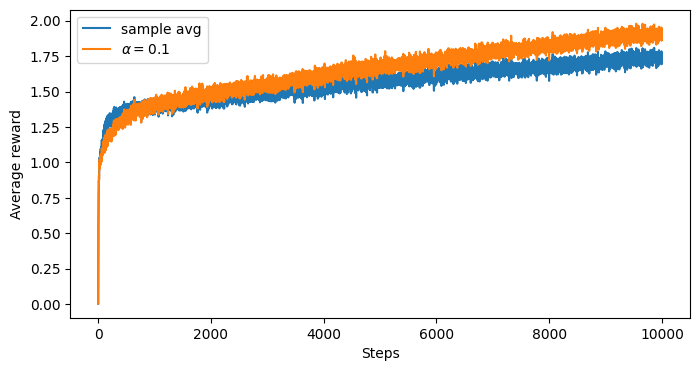

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(sample_avg_result[0], label="sample avg")
ax.plot(const_ss_result[0], label=r"$\alpha=0.1$")
ax.set_xlabel("Steps")
ax.set_ylabel("Average reward")
ax.legend();

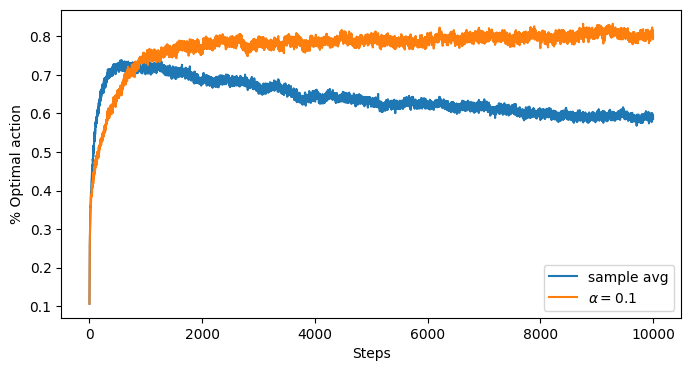

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(sample_avg_result[1], label="sample avg")
ax.plot(const_ss_result[1], label=r"$\alpha=0.1$")
ax.set_xlabel("Steps")
ax.set_ylabel("% Optimal action")
ax.legend();

# 3. Optimistic Initial Values

## 3.1 Stationary Setting

In [12]:
realistic_st_result = stationary_bandit_experiment(n=1_000, alpha=0.1)
const_ss_st_result = stationary_bandit_experiment(n=1_000, eps=0., alpha=0.1, 
                                                  init_reward=5.)

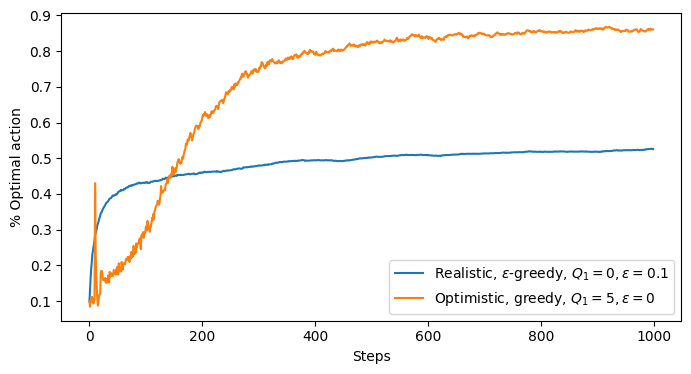

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(realistic_st_result[1], label=r"Realistic, $\epsilon$-greedy, $Q_1=0, \epsilon=0.1$")
ax.plot(const_ss_st_result[1], label=r"Optimistic, greedy, $Q_1=5, \epsilon=0$")
ax.set_xlabel("Steps")
ax.set_ylabel("% Optimal action")
ax.legend();

## 3.2 Nonstationary Setting (Figure 2.3)

In [14]:
realistic_nst_result = nonstationary_bandit_experiment(n=1_000, alpha=0.1)
const_ss_nst_result = nonstationary_bandit_experiment(n=1_000, eps=0., alpha=0.1, 
                                                      init_reward=5.)

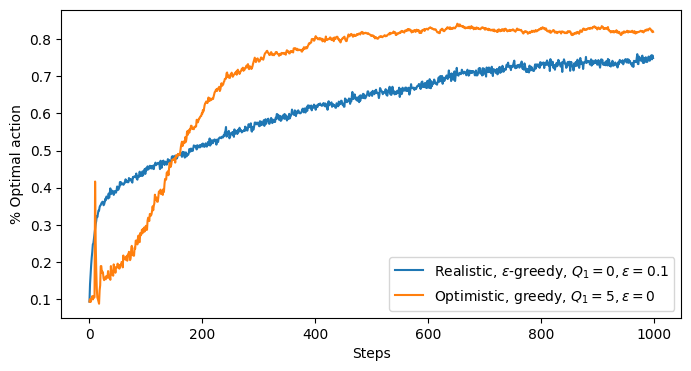

In [15]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(realistic_nst_result[1], label=r"Realistic, $\epsilon$-greedy, $Q_1=0, \epsilon=0.1$")
ax.plot(const_ss_nst_result[1], label=r"Optimistic, greedy, $Q_1=5, \epsilon=0$")
ax.set_xlabel("Steps")
ax.set_ylabel("% Optimal action")
ax.legend();

# 4. Upper-Confidence-Bound Action Selection

## 4.1 Stationary Setting (Figure 2.4)

In [16]:
ucb_st_result = stationary_bandit_experiment(eps=0., ucb_c=2.)
nonucb_st_result = stationary_bandit_experiment(eps=0.1)

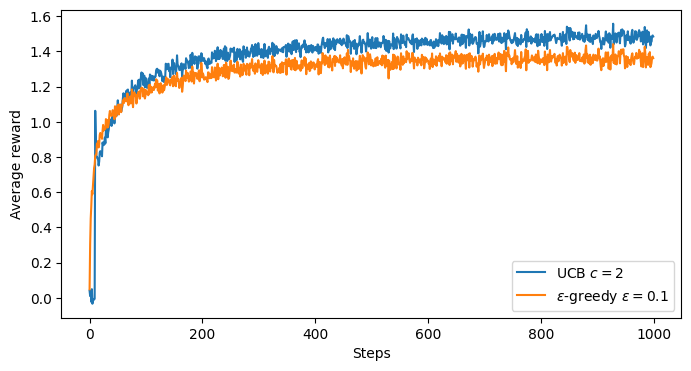

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ucb_st_result[0], label=r"UCB $c=2$")
ax.plot(nonucb_st_result[0], label=r"$\epsilon$-greedy $\epsilon=0.1$")
ax.set_xlabel("Steps")
ax.set_ylabel("Average reward")
ax.legend();

## 4.2 Nonstationary Setting

In [18]:
ucb_nst_result = nonstationary_bandit_experiment(eps=0., ucb_c=2.)
nonucb_nst_result = nonstationary_bandit_experiment(eps=0.1)

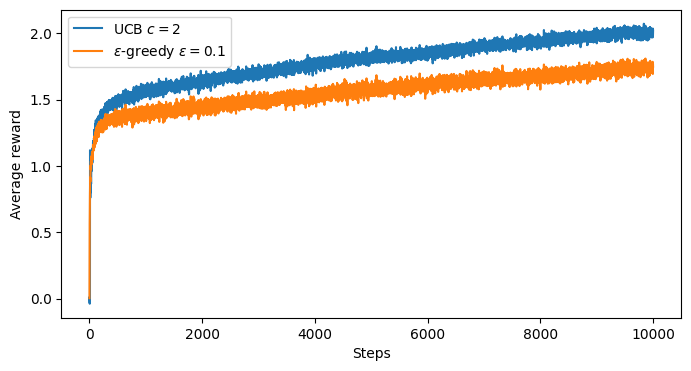

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(ucb_nst_result[0], label=r"UCB $c=2$")
ax.plot(nonucb_nst_result[0], label=r"$\epsilon$-greedy $\epsilon=0.1$")
ax.set_xlabel("Steps")
ax.set_ylabel("Average reward")
ax.legend();

# 5. Gradient Bandit Algorithms

## 5.1 Stationary Setting (Figure 2.5)

In [20]:
def stationary_gradient_bandit(key, k=10, n=1_000, alpha=0, init_true_reward=0.,
                               init_est_reward=0., baseline=True):
    key, subkey = jr.split(key)
    
    # Randomly sample means of the k rewards
    r_means = init_true_reward + jr.normal(subkey, shape=(k,))
    
    # Optimal action
    a_optimal = jnp.argmax(r_means)
    
    def _step(carry, args):
        # Carry is sample estimate of rewards
        r_bar, r_est, counts = carry
        key, i = args
        keys = jr.split(key, 3)
        
        # Make a choice
        idx = jr.permutation(x=len(r_est), key=keys[0])  # Shuffle rewards to randomly break ties
        choice = jr.choice(
            a=idx,
            key=keys[1],
            p=jax.nn.softmax(r_est[idx])
        )
        chose_optimal = (a_optimal == choice).astype(jnp.float32)
        
        # Receive reward
        r_curr = r_means[choice] + jr.normal(keys[2])
        r_bar = jnp.where(baseline, r_bar + 1/(i+1)*(r_curr - r_bar), 0.)
        counts = counts.at[choice].set(counts[choice] + 1)
        step_size = jnp.where(alpha > 0 and alpha <= 1, alpha, 1/counts[choice])
        r_est = jnp.where(
            jnp.arange(len(r_est)) == choice,
            r_est + step_size * (r_curr - r_bar) * (1 - jax.nn.softmax(r_est)),
            r_est - step_size * (r_curr - r_bar) * jax.nn.softmax(r_est),
        )
        
        return (r_bar, r_est, counts), (r_curr, chose_optimal)

    init = (0., init_est_reward * jnp.ones(k), jnp.zeros(k))
    _, (rewards, chose_optimal) = scan(_step, init, (jr.split(key, n), jnp.arange(n)))
    
    return rewards, chose_optimal

In [21]:
def stationary_gradient_bandit_experiment(n_iter=2_000, k=10, n=1_000, alpha=0.,
                                          init_true_reward=0., init_est_reward=0.,
                                          baseline=True, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
        
    keys = jr.split(key, n_iter)
    bandit = lambda key: stationary_gradient_bandit(key=key, k=k, n=n, alpha=alpha, 
                                                    init_true_reward=init_true_reward,
                                                    init_est_reward=init_est_reward,
                                                    baseline=baseline)
    rewards, chose_optimal = vmap(bandit)(keys)
    
    avg_rewards, avg_optimal_actions = \
        jnp.mean(rewards, axis=0), jnp.mean(chose_optimal, axis=0)
    
    return avg_rewards, avg_optimal_actions

In [22]:
gb_st_experiment = partial(stationary_gradient_bandit_experiment, init_true_reward=4.0)
gb_bl1_st_result = gb_st_experiment(alpha=0.1)
gb_bl2_st_result = gb_st_experiment(alpha=0.4)
gb_nbl1_st_result = gb_st_experiment(alpha=0.1, baseline=False)
gb_nbl2_st_result = gb_st_experiment(alpha=0.4, baseline=False)

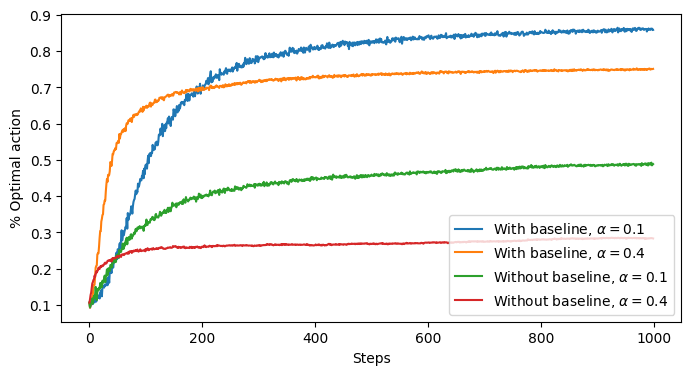

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(gb_bl1_st_result[1], label=r"With baseline, $\alpha=0.1$")
ax.plot(gb_bl2_st_result[1], label=r"With baseline, $\alpha=0.4$")
ax.plot(gb_nbl1_st_result[1], label=r"Without baseline, $\alpha=0.1$")
ax.plot(gb_nbl2_st_result[1], label=r"Without baseline, $\alpha=0.4$")
ax.set_xlabel("Steps")
ax.set_ylabel("% Optimal action")
ax.legend();

## 5.2 Nonstationary Setting

In [24]:
def nonstationary_gradient_bandit(key, k=10, n=10_000, alpha=0., init_true_reward=0.,
                                  init_est_reward=0., baseline=True):
    key, subkey = jr.split(key)
    
    def _step(carry, args):
        # Carry is sample estimate of rewards
        r_means, r_bar, r_est, counts = carry
        key, i = args
        keys = jr.split(key, 4)
        
        # Make a choice
        idx = jr.permutation(x=len(r_est), key=keys[0])  # Shuffle rewards to randomly break ties
        choice = jr.choice(
            a=idx,
            key=keys[1], 
            p=jax.nn.softmax(r_est[idx])
        )
        a_optimal = jnp.argmax(r_means) # Optimal action
        chose_optimal = (a_optimal == choice).astype(jnp.float32)
        
        # Receive reward
        r_curr = r_means[choice] + jr.normal(keys[2])
        r_bar = jnp.where(baseline, r_bar + 1/(i+1)*(r_curr - r_bar), 0.)
        counts = counts.at[choice].set(counts[choice] + 1)
        step_size = jnp.where(alpha > 0 and alpha <= 1, alpha, 1/counts[choice])
        r_est = jnp.where(
            jnp.arange(len(r_est)) == choice,
            r_est + step_size * (r_curr - r_bar) * (1 - jax.nn.softmax(r_est)),
            r_est - step_size * (r_curr - r_bar) * jax.nn.softmax(r_est),
        )
        
        # Random walk
        r_means += 0.01 * jr.normal(keys[3], shape=r_means.shape)
        
        return (r_means, r_bar, r_est, counts), (r_curr, chose_optimal)

    r_means = init_true_reward + jr.normal(subkey, shape=(k,))  # Randomly sample means of the k rewards
    init = (r_means, 0., init_est_reward * jnp.ones(k), jnp.zeros(k))
    _, (rewards, chose_optimal) = scan(_step, init, (jr.split(key, n), jnp.arange(n)))
    
    return rewards, chose_optimal

In [25]:
def nonstationary_gradient_bandit_experiment(n_iter=2_000, k=10, n=1_000, alpha=0.,
                                             init_true_reward=0., init_est_reward=0.,
                                             baseline=True, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
        
    keys = jr.split(key, n_iter)
    bandit = lambda key: nonstationary_gradient_bandit(key=key, k=k, n=n, alpha=alpha, 
                                                       init_true_reward=init_true_reward,
                                                       init_est_reward=init_est_reward,
                                                       baseline=baseline)
    rewards, chose_optimal = vmap(bandit)(keys)
    
    avg_rewards, avg_optimal_actions = \
        jnp.mean(rewards, axis=0), jnp.mean(chose_optimal, axis=0)
    
    return avg_rewards, avg_optimal_actions

In [26]:
gb_nst_experiment = partial(nonstationary_gradient_bandit_experiment, init_true_reward=4.0)
gb_bl1_nst_result = gb_nst_experiment(alpha=0.1)
gb_bl2_nst_result = gb_nst_experiment(alpha=0.4)
gb_nbl1_nst_result = gb_nst_experiment(alpha=0.1, baseline=False)
gb_nbl2_nst_result = gb_nst_experiment(alpha=0.4, baseline=False)

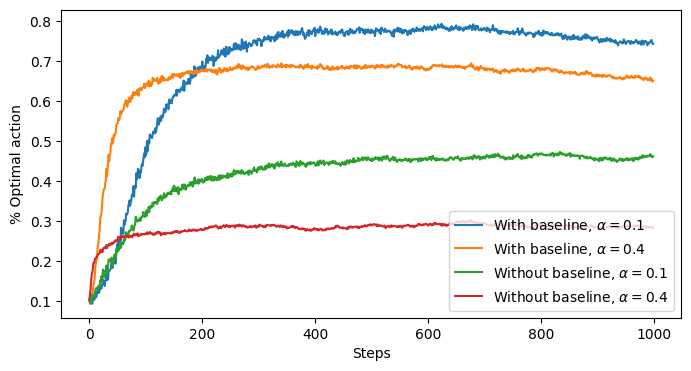

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(gb_bl1_nst_result[1], label=r"With baseline, $\alpha=0.1$")
ax.plot(gb_bl2_nst_result[1], label=r"With baseline, $\alpha=0.4$")
ax.plot(gb_nbl1_nst_result[1], label=r"Without baseline, $\alpha=0.1$")
ax.plot(gb_nbl2_nst_result[1], label=r"Without baseline, $\alpha=0.4$")
ax.set_xlabel("Steps")
ax.set_ylabel("% Optimal action")
ax.legend();